<a href="https://colab.research.google.com/github/Yash-slr/SCT_TrackCode_TaskNumber/blob/main/Handgesture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy opencv-python scikit-learn matplotlib pillow


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Top-level folders inside dataset path: ['02', '03', '04', '05', '06', '07', '08', '09']
Total images loaded: 370
Test accuracy: 1.00

Classification Report:
                precision    recall  f1-score   support

         02_l       0.00      0.00      0.00         0
      03_fist       0.00      0.00      0.00         0
04_fist_moved       0.00      0.00      0.00         0
     05_thumb       0.00      0.00      0.00         0
     06_index       0.00      0.00      0.00         0
        07_ok       0.00      0.00      0.00         0
08_palm_moved       0.00      0.00      0.00         0
         09_c       1.00      1.00      1.00        34
      10_down       1.00      1.00      1.00        40
      01_palm       0.00      0.00      0.00         0

     accuracy                           1.00        74
    macro avg       0.20      0.20      0.20       

Saving frame_01_05_0015.png to frame_01_05_0015.png
Prediction: 10_down
Confidence: 90.3%


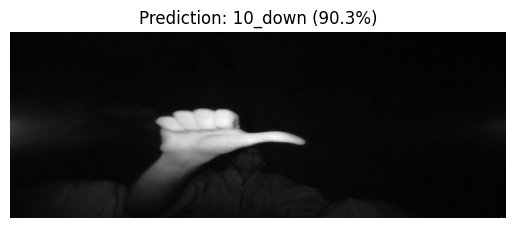

In [9]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/leapGestRecog'
img_size = 64

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
assert os.path.exists(dataset_path), f"Path not found: {dataset_path}"
print("Top-level folders inside dataset path:", os.listdir(dataset_path))
data = []
labels = []
class_names = []
class_to_id = {}
label_id = 0
for user_folder in sorted(os.listdir(dataset_path)):
    user_path = os.path.join(dataset_path, user_folder)
    if not os.path.isdir(user_path):
        continue
    for gesture_folder in sorted(os.listdir(user_path)):
        gesture_path = os.path.join(user_path, gesture_folder)
        if not os.path.isdir(gesture_path):
            continue
        if gesture_folder not in class_to_id:
            class_to_id[gesture_folder] = label_id
            class_names.append(gesture_folder)
            label_id += 1
        for img_file in os.listdir(gesture_path):
            img_path = os.path.join(gesture_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size)).flatten()
                data.append(img)
                labels.append(class_to_id[gesture_folder])
            else:
                print(f"Warning: Image not loaded - {img_path}")
data = np.array(data, dtype=np.float32) / 255.0
labels = np.array(labels)
print(f"Total images loaded: {len(data)}")
if len(data) == 0:
    raise ValueError("No image data found. Please check your dataset path and image folders.")
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
n_components = min(150, X_train.shape[0], X_train.shape[1])
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.2f}")
all_labels = list(range(len(class_names)))
print("\nClassification Report:\n", classification_report(
    y_test, y_pred, labels=all_labels, target_names=class_names, zero_division=0))
from google.colab import files
from PIL import Image
uploaded = files.upload()
for filename in uploaded.keys():
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img_resized = cv2.resize(img, (img_size, img_size)).flatten()
        img_scaled = scaler.transform([img_resized / 255.0])
        img_pca = pca.transform(img_scaled)
        pred = clf.predict(img_pca)[0]
        proba = clf.predict_proba(img_pca)[0]
        confidence = np.max(proba) * 100
        print(f"Prediction: {class_names[pred]}")
        print(f"Confidence: {confidence:.1f}%")
        # Show the image
        plt.imshow(img, cmap='gray')
        plt.title(f'Prediction: {class_names[pred]} ({confidence:.1f}%)')
        plt.axis('off')
        plt.show()
    else:
        print("Could not read uploaded image.")
